<a href="https://colab.research.google.com/github/HoseinNekouei/US_Airline_Sentiment_Classification/blob/main/pyTorch_US_airline_tweet_fine_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libreries and important requirment**

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!mkdir /content/dataset
!cp /content/drive/MyDrive/Projects/Sentiment_Analysis/Augmented_dataset_US_airline_Tweet.csv /content/dataset

mkdir: cannot create directory ‘/content/dataset’: File exists


# **Load Dataset and Pre-Processing data**

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

class DataVisualizer:
    @staticmethod
    def visualize_sentiment(data):
        sentiment_count = data.airline_sentiment.value_counts()
        colors = sns.color_palette('pastel', 3)
        labels = ['Negative', 'Neutral', 'Positive']
        explode = [0.01, 0.01, 0.01]

        plt.figure(figsize=(4, 4))
        sentiment_count.plot(
            kind='pie',
            colors=colors,
            labels=labels,
            explode=explode,
            shadow=True,
            autopct='%.2f',
            fontsize=12,
        )
        plt.title('Total Tweets for Each Sentiment')
        plt.ylabel(' ')
        plt.show()

In [4]:
import logging
import string
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

class TextProcessor:
    @staticmethod
    def class_mapping(sentiment: str)-> int:
        """ Map class labels to new values."""

        if sentiment== 'negative':
          return 0
        elif sentiment== 'neutral':
          return 1
        elif sentiment== 'positive':
          return 2
        else:
          logging.warning(f'Unknown Sentiment {sentiment}')
          return -1

    @staticmethod
    def remove_stopwords(text):
        """
          Stop words are commonly used words in a language that are often filtered out in text processing
          because they carry little meaningful information on their own.
          Examples in English include words like "the," "is," "in," "and," "a," etc.
          They are typically removed in Natural Language Processing (NLP) tasks to improve the efficiency of algorithms or the quality of analysis.
        """
        text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
        return text

    # Remove url
    @staticmethod
    def remove_urls(text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)

    # Remove html
    @staticmethod
    def remove_html(text):
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)

    # Remove @username
    @staticmethod
    def remove_username(text):
        return re.sub('@[^\s]+','',text)

    # Decontraction text
    @staticmethod
    def decontraction(text):
        text = re.sub(r"won\'t", " will not", text)
        text = re.sub(r"won\'t've", " will not have", text)
        text = re.sub(r"can\'t", " can not", text)
        text = re.sub(r"don\'t", " do not", text)
        text = re.sub(r"didn\'t", " did not", text)
        text = re.sub(r"can\'t've", " can not have", text)
        text = re.sub(r"ma\'am", " madam", text)
        text = re.sub(r"let\'s", " let us", text)
        text = re.sub(r"ain\'t", " am not", text)
        text = re.sub(r"shan\'t", " shall not", text)
        text = re.sub(r"sha\n't", " shall not", text)
        text = re.sub(r"o\'clock", " of the clock", text)
        text = re.sub(r"y\'all", " you all", text)
        text = re.sub(r"n\'t", " not", text)
        text = re.sub(r"n\'t've", " not have", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'s", " is", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'d've", " would have", text)
        text = re.sub(r"\'ll", " will", text)
        text = re.sub(r"\'ll've", " will have", text)
        text = re.sub(r"\'t", " not", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"\'m", " am", text)
        text = re.sub(r"\'re", " are", text)
        return text

    @staticmethod
    def normalize_repeated_chars(text):
        # Step 1: Preserve ellipses by temporarily replacing them with a unique placeholder
        placeholder = "<ELLIPSIS>"
        text = re.sub(r'\.{3,}', placeholder, text)  # Replace ellipses with a placeholder

        # Step 2: Normalize repeated characters. Matches any character repeated 3 or more times like cooool -> cool
        text = re.sub(r'(.)\1{2,}', r'\1', text)

        # Step 3: Restore ellipses by replacing the placeholder with '...'
        text = text.replace(placeholder, '...')
        return text

    @staticmethod
    # Separate alphabetic characters and numeric characters to improce tokenization
    def seperate_alphanumeric(text):
        words = re.findall(r"[^\W\d_]+|\d+|\W+", text)
        return " ".join(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
import pandas as pd
from typing import Optional

class DatasetLoader:
    def __init__(self, *, file_path: str):
        self.file_path: str = file_path
        self._data: Optional[pd.DataFrame] = None

    def loader(self) -> None:
        if not os.path.exists(self.file_path):
            raise FileNotFoundError(f"File not found: {self.file_path}")
        self._data = pd.read_csv(self.file_path, nrows=100)

    def visualize_data(self):
        if self._data is not None:
            DataVisualizer.visualize_sentiment(self._data)
        else:
            raise ValueError("Data not loaded. Call `loader()` first.")

    def map_classes(self):
        if self._data is not None:
            # Apply the static method to map classes
            self._data['labels']= self._data['airline_sentiment'].apply(TextProcessor.class_mapping)
        else:
            raise ValueError("Data not loaded. Call `loader()` first.")

    def text_preprocessing(self):
        if self._data is not None:
            # Apply the static method to remove html
            self._data['revised_text']= self._data['text'].apply(TextProcessor.remove_html)

            # Apply the static method to remove urls
            self._data['revised_text']= self._data['revised_text'].apply(TextProcessor.remove_urls)

            # Apply the static method to decontract text.
            self._data['revised_text']= self._data['revised_text'].apply(TextProcessor.decontraction)

            # Convert texts to lowercase.
            self._data['revised_text']= self._data['revised_text'].apply(lambda x: x.lower())

            # Replace Repeated Characters with a Single Instance
            self._data['revised_text']= self._data['revised_text'].apply(TextProcessor.normalize_repeated_chars)

            # Separate alphabetic characters and numeric characters
            # self._data['revised_text']= self._data['revised_text'].apply(TextProcessor.seperate_alphanumeric)

            # Apply the static method to remove stop words
            # self._data['revised_text']= self._data['revised_text'].apply(TextProcessor.remove_stopwords)

            # Apply the static method to remove @username
            # self._data['revised_text']= self._data['revised_text'].apply(TextProcessor.remove_username)
        else:
            raise ValueError("Data not loaded. Call 'loader()' first")

    def __str__(self):
        if self._data is None:
            return "Data not loaded."
        information = [
            f'Categories of : {self._data.airline_sentiment.value_counts().to_dict()}',
            f'\nInformation: {self._data.info()}'
        ]
        return ', '.join(information)

    def __call__(self):
        self.loader()
        self.visualize_data()
        self.map_classes()
        self.text_preprocessing()


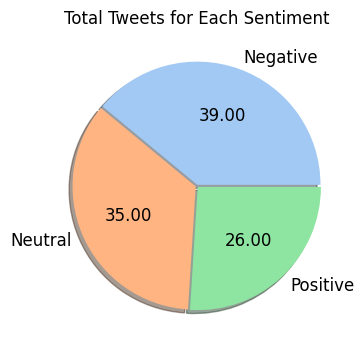

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               100 non-null    object
 1   airline_sentiment  100 non-null    object
 2   negativereason     35 non-null     object
 3   positivereason     26 non-null     object
 4   labels             100 non-null    int64 
 5   revised_text       100 non-null    object
dtypes: int64(1), object(5)
memory usage: 4.8+ KB
Categories of : {'neutral': 39, 'negative': 35, 'positive': 26}, 
Information: None


In [6]:
file_path= '/content/dataset/Augmented_dataset_US_airline_Tweet.csv'
loader= DatasetLoader(file_path= file_path)
loader()

print(loader)

# Split data into Trainset and Testset

In [7]:
from sklearn.model_selection import train_test_split

def split_dataset(*,features, labels):
  X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, stratify= labels, random_state= 42)

  message_list= [
    f'X_train length: {len(X_train)}',
    f'X_test length: {len(X_test)}',
    f'y_train length: {len(y_train)}',
    f'y_test length: {len(y_test)}'
  ]
  message_list= ','.join(message_list)
  print(message_list)

  return X_train, X_test, y_train, y_test


features= loader._data['revised_text']
labels= loader._data['labels']

X_train, X_test, y_train, y_test= split_dataset(features= features, labels= labels)


X_train length: 75,X_test length: 25,y_train length: 75,y_test length: 25


#**Loade Tokenizer and Tokenize tweets**

In [8]:
from transformers import T5Tokenizer
flan_model_name= "google/flan-t5-XL"

flan_tokenizer = T5Tokenizer.from_pretrained(flan_model_name)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [9]:
import torch
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [10]:
# tokenize the text data
device= 'cuda' if torch.cuda.is_available() else 'cpu'

if not isinstance(X_train, list):
  X_train= X_train.tolist()

# Define a prompt
prompt= 'Provide a brief explanation of of your interpretation of the key emotional aspects and tone: '

#Combine the propmpt with each tweet in X_train
prompted_tweets= [f'{prompt} {tweet}' for tweet in X_train]

inputs= flan_tokenizer(
    prompted_tweets,
    padding=True,
    truncation= True,
    return_tensors= 'pt')

input_ids= inputs['input_ids'].to(device)
attention_mask= inputs['attention_mask'].to(device)

input_ids, attention_mask,torch.cuda.empty_cache()

(tensor([[7740,    3,    9,  ...,    0,    0,    0],
         [7740,    3,    9,  ...,    0,    0,    0],
         [7740,    3,    9,  ...,    0,    0,    0],
         ...,
         [7740,    3,    9,  ...,    0,    0,    0],
         [7740,    3,    9,  ...,    0,    0,    0],
         [7740,    3,    9,  ...,    0,    0,    0]], device='cuda:0'),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 None)

# **Load Model**

In [11]:
from transformers import T5ForConditionalGeneration

flan_model= T5ForConditionalGeneration.from_pretrained(flan_model_name)
flan_model.half() # Convert model weights to FP16
flan_model.to(device)

config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 2048)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 2048)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=2048, out_features=2048, bias=False)
              (k): Linear(in_features=2048, out_features=2048, bias=False)
              (v): Linear(in_features=2048, out_features=2048, bias=False)
              (o): Linear(in_features=2048, out_features=2048, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=2048, out_features=5120, bias=False)
              (wi_1): Linear(in_features=2048, out_features=5120, bias=False)
       

In [12]:
# Generate outputs for the batch
outputs = flan_model.generate(
    input_ids=input_ids,
    attention_mask=attention_mask,
    max_length=50,
    num_beams=2,
    early_stopping=True, # Stop generation if EOS token is reached
)


In [17]:
# Decode the generated outputs
generated_texts = flan_tokenizer.batch_decode(outputs, skip_special_tokens=True)

#Combine generated text with original tweets
augmented_tweets = [f"{original}; {generated}" for original, generated in zip(X_train, generated_texts)]

print(augmented_tweets[9])

@virginamerica so excited for my first cross country flight lax to mco i have heard nothing but great things about virgin america. #29daystogo; i am so excited for my first cross country flight


In [46]:
# !pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 23.5 MB/s eta 0:00:00


In [ ]:
from datasets import Dataset

# Create a Hugging Face Dataset
augmented_dataset = Dataset.from_dict({
    "text": augmented_tweets,
    "label": y_train
})

In [ ]:
# @title Default title



In [ ]:
raw_text= loader._data[['text', 'airline_sentiment','revised_text' ,'labels']].iloc[56]
print(raw_text.text), print(raw_text.revised_text), print(raw_text.airline_sentiment)

In [ ]:
from transformers import pipeline

In [ ]:
classifier= pipeline('sentiment-analysis', model='cardiffnlp/twitter-roberta-base-sentiment-latest')

In [ ]:
print(classifier(raw_text.text))
print(classifier(raw_text.revised_text))